In [442]:
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [443]:
df=pd.read_csv("132_Temp.csv")

In [444]:
df.head()

,Date,Temperature,Humidity,Outside Temperature,Previous Date,Temperature on Previous day,2 days before Date,Temperature 2 days before
0,1/15/2020 1:44,70.7,64.75,68,1/14/2020 1:44,69.8,1/13/2020 1:44,68.1
1,1/15/2020 3:44,70.6,66.51,66,1/14/2020 3:44,69.8,1/13/2020 3:44,68.0
2,1/15/2020 5:44,70.6,67.79,68,1/14/2020 5:44,69.7,1/13/2020 5:44,67.8
3,1/15/2020 7:44,69.8,60.85,72,1/14/2020 7:44,71.8,1/13/2020 7:44,66.7
4,1/15/2020 9:44,70.6,57.82,75,1/14/2020 9:44,72.5,1/13/2020 9:44,68.6


In [445]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 8 columns):
Date                           384 non-null object
Temperature                    384 non-null float64
Humidity                       384 non-null float64
Outside Temperature            384 non-null int64
Previous Date                  384 non-null object
Temperature on Previous day    384 non-null float64
2 days before Date             384 non-null object
Temperature 2 days before      384 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 24.1+ KB


In [446]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [447]:
df.head()

,Temperature,Humidity,Outside Temperature,Previous Date,Temperature on Previous day,2 days before Date,Temperature 2 days before
Date,,,,,,,
2020-01-15 01:44:00,70.7,64.75,68,1/14/2020 1:44,69.8,1/13/2020 1:44,68.1
2020-01-15 03:44:00,70.6,66.51,66,1/14/2020 3:44,69.8,1/13/2020 3:44,68.0
2020-01-15 05:44:00,70.6,67.79,68,1/14/2020 5:44,69.7,1/13/2020 5:44,67.8
2020-01-15 07:44:00,69.8,60.85,72,1/14/2020 7:44,71.8,1/13/2020 7:44,66.7
2020-01-15 09:44:00,70.6,57.82,75,1/14/2020 9:44,72.5,1/13/2020 9:44,68.6


In [448]:
df.dropna(inplace=True)

In [449]:
ts=df.loc['1/15/2020':'2/15/2020',['Temperature','Humidity','Outside Temperature','Temperature on Previous day','Temperature 2 days before']]
#ts=pd.concat([df.loc['2/03/2020':'2/07/2020'],df.loc['2/10/2020':'2/14/2020']])[['Temperature','Humidity','Outside Temperature','Temperature on Previous day','Temperature 2 days before']]
ts=pd.DataFrame(ts)
ts.head()

,Temperature,Humidity,Outside Temperature,Temperature on Previous day,Temperature 2 days before
Date,,,,,
2020-01-15 01:44:00,70.7,64.75,68,69.8,68.1
2020-01-15 03:44:00,70.6,66.51,66,69.8,68.0
2020-01-15 05:44:00,70.6,67.79,68,69.7,67.8
2020-01-15 07:44:00,69.8,60.85,72,71.8,66.7
2020-01-15 09:44:00,70.6,57.82,75,72.5,68.6


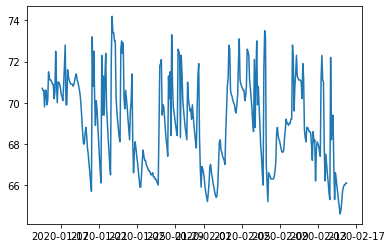

In [450]:
plt.plot(ts['Temperature'])

In [451]:
values=ts.values

In [452]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [453]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [454]:
reframed = series_to_supervised(scaled, 12, 1)

In [455]:
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
12,0.635417,0.726937,0.804348,0.511111,0.322222,0.625000,0.759475,0.760870,0.511111,0.311111,...,0.677083,0.681087,0.717391,0.622222,0.522222,0.666667,0.740802,0.717391,0.611111,0.511111
13,0.625000,0.759475,0.760870,0.511111,0.311111,0.625000,0.783139,0.804348,0.500000,0.288889,...,0.666667,0.740802,0.717391,0.611111,0.511111,0.656250,0.768904,0.760870,0.600000,0.511111
14,0.625000,0.783139,0.804348,0.500000,0.288889,0.541667,0.654835,0.891304,0.733333,0.166667,...,0.656250,0.768904,0.760870,0.600000,0.511111,0.656250,0.799963,0.760870,0.600000,0.500000
15,0.541667,0.654835,0.891304,0.733333,0.166667,0.625000,0.598817,0.956522,0.811111,0.377778,...,0.656250,0.799963,0.760870,0.600000,0.500000,0.583333,0.636532,0.847826,0.511111,0.733333
16,0.625000,0.598817,0.956522,0.811111,0.377778,0.625000,0.598262,0.956522,0.822222,0.411111,...,0.583333,0.636532,0.847826,0.511111,0.733333,0.614583,0.583657,0.913043,0.600000,0.811111


In [456]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[61,62,63,64]], axis=1, inplace=True)

In [457]:
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),...,var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
12,0.635417,0.726937,0.804348,0.511111,0.322222,0.625000,0.759475,0.760870,0.511111,0.311111,...,0.644112,0.760870,0.622222,0.544444,0.677083,0.681087,0.717391,0.622222,0.522222,0.666667
13,0.625000,0.759475,0.760870,0.511111,0.311111,0.625000,0.783139,0.804348,0.500000,0.288889,...,0.681087,0.717391,0.622222,0.522222,0.666667,0.740802,0.717391,0.611111,0.511111,0.656250
14,0.625000,0.783139,0.804348,0.500000,0.288889,0.541667,0.654835,0.891304,0.733333,0.166667,...,0.740802,0.717391,0.611111,0.511111,0.656250,0.768904,0.760870,0.600000,0.511111,0.656250
15,0.541667,0.654835,0.891304,0.733333,0.166667,0.625000,0.598817,0.956522,0.811111,0.377778,...,0.768904,0.760870,0.600000,0.511111,0.656250,0.799963,0.760870,0.600000,0.500000,0.583333
16,0.625000,0.598817,0.956522,0.811111,0.377778,0.625000,0.598262,0.956522,0.822222,0.411111,...,0.799963,0.760870,0.600000,0.500000,0.583333,0.636532,0.847826,0.511111,0.733333,0.614583


In [458]:
# split into train and test sets
values = reframed.values
n_train = 276
train = values[:n_train, :]
test = values[n_train:, :]

In [459]:
test.shape

(96, 61)

In [460]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape,test_X.shape, train_y.shape,test_y.shape)

(276, 60) (96, 60) (276,) (96,)


In [461]:
# specify the number of lag hours
n_hours = 12
n_features = 5

In [462]:
# split into input and outputs
#n_obs = n_hours * n_features
#train_X, train_y = train[:, :n_obs], train[:, -n_features]
#test_X, test_y = test[:, :n_obs], test[:, -n_features]
#print(train_X.shape,test_X.shape, train_y.shape,test_y.shape)

In [463]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

In [464]:
print(train_X.shape,test_X.shape, train_y.shape,test_y.shape)

(276, 12, 5) (96, 12, 5) (276,) (96,)


Train on 276 samples, validate on 96 samples
Epoch 1/30
 - 1s - loss: 0.2865 - val_loss: 0.1962
Epoch 2/30
 - 0s - loss: 0.1698 - val_loss: 0.1676
Epoch 3/30
 - 0s - loss: 0.1504 - val_loss: 0.1385
Epoch 4/30
 - 0s - loss: 0.1457 - val_loss: 0.1425
Epoch 5/30
 - 0s - loss: 0.1379 - val_loss: 0.1349
Epoch 6/30
 - 0s - loss: 0.1305 - val_loss: 0.1193
Epoch 7/30
 - 0s - loss: 0.1296 - val_loss: 0.1160
Epoch 8/30
 - 0s - loss: 0.1271 - val_loss: 0.1102
Epoch 9/30
 - 0s - loss: 0.1267 - val_loss: 0.1089
Epoch 10/30
 - 0s - loss: 0.1239 - val_loss: 0.1056
Epoch 11/30
 - 0s - loss: 0.1235 - val_loss: 0.1053
Epoch 12/30
 - 0s - loss: 0.1199 - val_loss: 0.1013
Epoch 13/30
 - 0s - loss: 0.1225 - val_loss: 0.1023
Epoch 14/30
 - 0s - loss: 0.1174 - val_loss: 0.0980
Epoch 15/30
 - 0s - loss: 0.1201 - val_loss: 0.0984
Epoch 16/30
 - 0s - loss: 0.1159 - val_loss: 0.0953
Epoch 17/30
 - 0s - loss: 0.1179 - val_loss: 0.0962
Epoch 18/30
 - 0s - loss: 0.1130 - val_loss: 0.0922
Epoch 19/30
 - 0s - loss: 0.

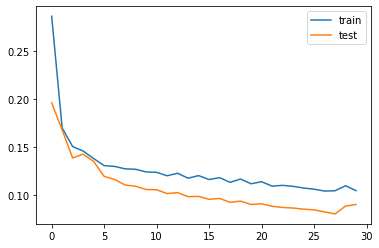

In [465]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [466]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))

In [467]:
test_X.shape

(96, 60)

In [468]:
# invert scaling for forecast
testy_forecast = np.zeros(shape=(len(test_y), 5))

testy_forecast[:,0] = yhat[:,0]

inv_yhat = scaler.inverse_transform(testy_forecast)[:,0]

In [469]:
# invert scaling for actual test
testy_actual = np.zeros(shape=(len(test_y), 5))

testy_actual[:,0] = test_y

inv_y = scaler.inverse_transform(testy_actual)[:,0]

In [470]:
# invert scaling for actual train
trainy_actual = np.zeros(shape=(len(train_y), 5))

trainy_actual[:,0] = train_y

inv_y_train = scaler.inverse_transform(trainy_actual)[:,0]

In [471]:
inv_yhat

array([66.83279023, 66.71898918, 66.65916433, 66.69746857, 67.17735882,
       67.19570513, 67.40591879, 67.51871262, 67.74353466, 68.0306469 ,
       68.11620922, 68.04681711, 67.95036001, 67.84166346, 67.74221315,
       67.73436308, 68.1896966 , 68.60414009, 68.92450428, 68.85100546,
       68.94392462, 68.88997717, 68.90458412, 68.94223146, 69.04037285,
       69.13115253, 69.26500864, 69.3384285 , 70.38621864, 70.88844318,
       70.5721262 , 70.76841068, 71.09820709, 71.49504356, 71.36835346,
       71.28322487, 71.23393631, 71.19305115, 71.17116089, 71.20107689,
       71.16094131, 71.54662495, 71.32075634, 70.71147919, 70.10799103,
       69.5985178 , 69.36633892, 69.17315607, 69.03343601, 68.94037924,
       68.95282555, 68.99825544, 69.13572016, 69.03470144, 69.14190969,
       69.06303501, 69.11869278, 68.61395168, 68.63127232, 68.61828842,
       68.50478249, 68.36091595, 68.14238243, 67.93318014, 68.75568991,
       69.60854797, 69.81115818, 69.72368355, 68.80171089, 67.82

In [472]:
inv_y

array([66.3, 66.3, 66.3, 66.3, 66.4, 66.7, 67.1, 68.5, 68.8, 68.4, 68.2,
       68.1, 67.9, 67.7, 67.6, 67.6, 67.7, 68.3, 68.7, 69.2, 69. , 69. ,
       68.9, 69. , 69. , 69.2, 69.2, 72.8, 72.2, 69.6, 70.8, 71.4, 72.3,
       71.3, 71.2, 71.1, 71.1, 71.1, 71. , 70.2, 71.9, 71.2, 68.7, 68.3,
       68.1, 68.8, 68.8, 68.7, 68.6, 68.6, 68.5, 67.9, 67.2, 68.6, 68.1,
       68.2, 66.2, 67.7, 68.1, 68. , 67.9, 67.6, 67.4, 71.2, 72.3, 71.1,
       71. , 67.7, 66.2, 67.5, 67. , 66.5, 66.1, 65.6, 65.3, 72.2, 68.2,
       69. , 69.4, 66.9, 65.3, 66.6, 66.3, 65.9, 65.6, 65.2, 64.9, 64.6,
       64.8, 65.2, 65.7, 65.9, 66. , 66. , 66.1, 66.1])

In [473]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.289


In [474]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Temperature (F)')

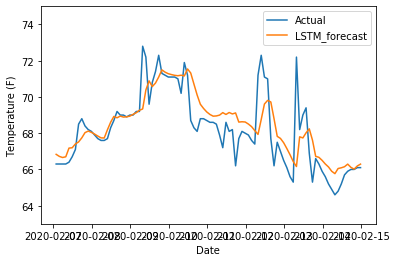

In [475]:
plt.plot(ts.index[276:372],inv_y,label='Actual')
plt.plot(ts.index[276:372],inv_yhat,label='LSTM_forecast')
plt.legend(loc="upper right")
plt.ylim(63,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

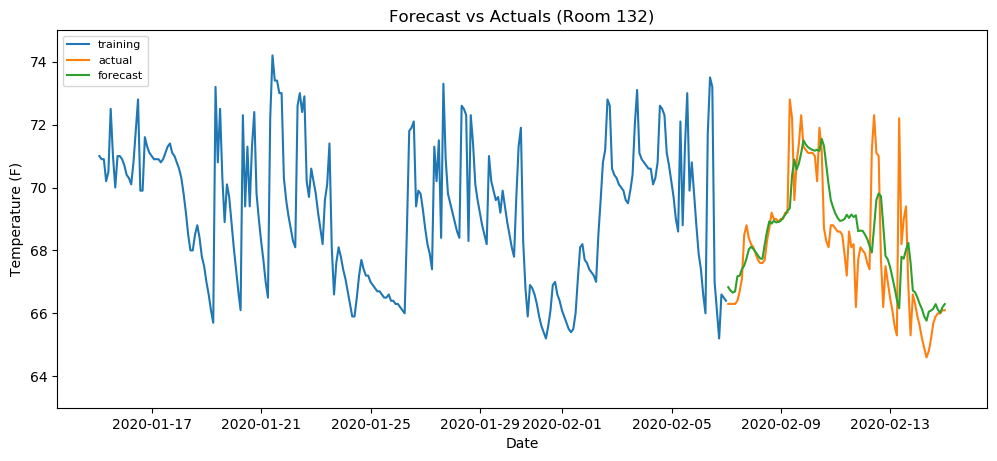

In [476]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(ts.index[:276],inv_y_train, label='training')
plt.plot(ts.index[276:372],inv_y, label='actual')
plt.plot(ts.index[276:372],inv_yhat, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 132)')
plt.legend(loc='upper left', fontsize=8)
plt.ylim(63,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

# Linear regression

In [477]:
from sklearn.linear_model import LinearRegression

In [478]:
regressor = LinearRegression()

In [479]:
train_X_lr, train_y_lr = train[:, :-1], train[:, -1]
test_X_lr, test_y_lr = test[:, :-1], test[:, -1]

In [480]:
regressor.fit(train_X_lr,train_y_lr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [498]:
coef=regressor.fit(train_X_lr,train_y_lr).coef_.reshape(5,12)
coef_df=pd.DataFrame(coef)
coef_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.345571,-0.073105,0.038587,-0.093212,0.109292,0.020173,0.219409,0.002921,-0.039386,-0.109626,0.063581,-0.333420
1,0.119845,0.048767,0.035981,-0.069397,-0.197350,0.028574,0.012876,-0.060958,0.094576,0.532550,-0.092209,0.030757
2,-0.076839,0.045722,-0.509680,0.010195,0.028567,0.048417,-0.061032,0.194912,-0.127519,-0.043708,-0.003895,0.058704
3,0.298540,-0.008529,-0.021707,-0.046707,0.089538,-0.317823,0.266100,0.020167,0.001045,-0.175623,-0.150962,-0.103856
4,-0.044425,-0.009576,0.055779,0.203273,-0.169064,0.076356,-0.128119,0.664934,0.051488,0.129207,-0.261528,0.158645


In [481]:
y_pred= regressor.predict(test_X_lr)

In [482]:
#Invert scaling for forecast
testy_forecast_lr = np.zeros(shape=(len(test_y_lr), 5))

testy_forecast_lr[:,0] = y_pred

inv_yhat_lr = scaler.inverse_transform(testy_forecast_lr)[:,0]

In [483]:
inv_yhat_lr.shape

(96,)

In [484]:
#Invert scaling for actual
# invert scaling for actual

testy_actual_lr = np.zeros(shape=(len(test_y_lr), 5))

testy_actual_lr[:,0] = test_y_lr

inv_y_lr = scaler.inverse_transform(testy_actual_lr)[:,0]

In [485]:
inv_y_lr

array([66.3, 66.3, 66.3, 66.3, 66.4, 66.7, 67.1, 68.5, 68.8, 68.4, 68.2,
       68.1, 67.9, 67.7, 67.6, 67.6, 67.7, 68.3, 68.7, 69.2, 69. , 69. ,
       68.9, 69. , 69. , 69.2, 69.2, 72.8, 72.2, 69.6, 70.8, 71.4, 72.3,
       71.3, 71.2, 71.1, 71.1, 71.1, 71. , 70.2, 71.9, 71.2, 68.7, 68.3,
       68.1, 68.8, 68.8, 68.7, 68.6, 68.6, 68.5, 67.9, 67.2, 68.6, 68.1,
       68.2, 66.2, 67.7, 68.1, 68. , 67.9, 67.6, 67.4, 71.2, 72.3, 71.1,
       71. , 67.7, 66.2, 67.5, 67. , 66.5, 66.1, 65.6, 65.3, 72.2, 68.2,
       69. , 69.4, 66.9, 65.3, 66.6, 66.3, 65.9, 65.6, 65.2, 64.9, 64.6,
       64.8, 65.2, 65.7, 65.9, 66. , 66. , 66.1, 66.1])

Text(0, 0.5, 'Temperature (F)')

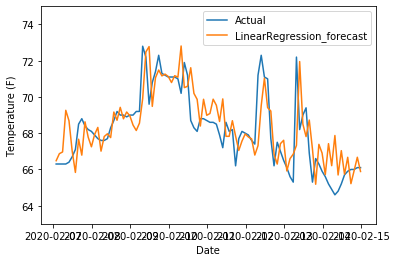

In [486]:
plt.plot(ts.index[276:372],inv_y_lr,label='Actual')
plt.plot(ts.index[276:372],inv_yhat_lr,label='LinearRegression_forecast')
plt.legend(loc="upper right")
plt.ylim(63,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')

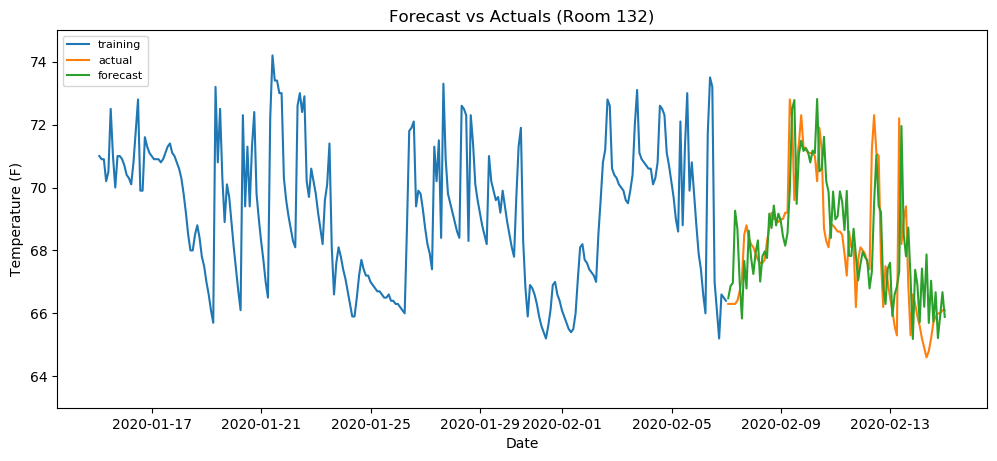

In [487]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(ts.index[:276],inv_y_train, label='training')
plt.plot(ts.index[276:372],inv_y_lr, label='actual')
plt.plot(ts.index[276:372],inv_yhat_lr, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals (Room 132)')
plt.legend(loc='upper left', fontsize=8)
plt.ylim(63,75)
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.show()

In [488]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_lr, inv_yhat_lr))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.433
